In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage.feature import graycomatrix, graycoprops
from skimage import exposure

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, silhouette_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import joblib


In [ ]:
# ======================================================
# KONFIGURASI
# ======================================================
IMAGE_DIR = "all_datasetv2"
LABEL_CSV = "all_dataset2.csv"
IMG_SIZE = 128
RANDOM_STATE = 42

In [3]:
# ======================================================
# LOAD LABEL (GROUND TRUTH)
# ======================================================
def load_label(label_path):
    df = pd.read_csv(label_path, header=None, skiprows=1)
    df.columns = ["filename", "l1", "l2", "l3", "l4", "l5", "l6"]

    df["label"] = df[["l1","l2","l3","l4","l5","l6"]].idxmax(axis=1)
    df["label"] = df["label"].str.replace("l", "").astype(int)

    return df[["filename", "label"]]

label_df = load_label(LABEL_CSV)
print("Jumlah data berlabel:", len(label_df))

Jumlah data berlabel: 5142


In [4]:
def segment_object(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # threshold kasar warna manggis
    lower = np.array([0, 30, 30])
    upper = np.array([180, 255, 255])
    mask = cv2.inRange(hsv, lower, upper)

    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return img

    c = max(contours, key=cv2.contourArea)
    x,y,w,h = cv2.boundingRect(c)

    return img[y:y+h, x:x+w]


In [5]:
def normalize_lighting(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    l = clahe.apply(l)

    lab = cv2.merge((l,a,b))
    return cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)


In [6]:
def augment_image(img):
    augmented = []

    augmented.append(cv2.flip(img, 1))                # flip
    augmented.append(cv2.rotate(img, cv2.ROTATE_90))  # rotasi
    augmented.append(cv2.GaussianBlur(img,(5,5),0))   # blur ringan

    return augmented


In [7]:
def extract_color_features(rgb):
    return [
        np.mean(rgb[:,:,0]), np.mean(rgb[:,:,1]), np.mean(rgb[:,:,2]),
        np.std(rgb[:,:,0]),  np.std(rgb[:,:,1]),  np.std(rgb[:,:,2])
    ]

def extract_texture_features(gray):
    gray = (gray * 255).astype(np.uint8)

    glcm = graycomatrix(
        gray,
        distances=[1],
        angles=[0],
        levels=256,
        symmetric=True,
        normed=True
    )

    return [
        graycoprops(glcm,'contrast')[0,0],
        graycoprops(glcm,'homogeneity')[0,0],
        graycoprops(glcm,'energy')[0,0],
        graycoprops(glcm,'correlation')[0,0]
    ]

def extract_all_features(img):
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255.0
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)/255.0

    return extract_color_features(rgb) + extract_texture_features(gray)


In [11]:
X, y = [], []

for _, row in label_df.iterrows():
    path = os.path.join(IMAGE_DIR, row["filename"])
    if not os.path.exists(path):
        continue

    img = cv2.imread(path)
    img = segment_object(img)
    img = normalize_lighting(img)

    X.append(extract_all_features(img))
    y.append(row["label"])

    def augment_image(img):
        augmented = []

        augmented.append(cv2.flip(img, 1))  # horizontal flip
        augmented.append(cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE))
        augmented.append(cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE))
        augmented.append(cv2.GaussianBlur(img, (5,5), 0))

        return augmented

X = np.array(X)
y = np.array(y)

print("Shape X:", X.shape)
print("Distribusi label:\n", pd.Series(y).value_counts())


Shape X: (5142, 10)
Distribusi label:
 1    2602
2     723
3     674
4     584
5     529
6      30
Name: count, dtype: int64


In [12]:
X_km = MinMaxScaler().fit_transform(X)

scores = {}
for k in range(2,7):
    labels = KMeans(k, random_state=RANDOM_STATE, n_init=20).fit_predict(X_km)
    scores[k] = silhouette_score(X_km, labels)

best_k = max(scores, key=scores.get)
print("Silhouette:", scores)
print("Best k:", best_k)


Silhouette: {2: np.float64(0.275803988736705), 3: np.float64(0.3205719421195435), 4: np.float64(0.3088791149779729), 5: np.float64(0.2316541067680605), 6: np.float64(0.2361037801227013)}
Best k: 3


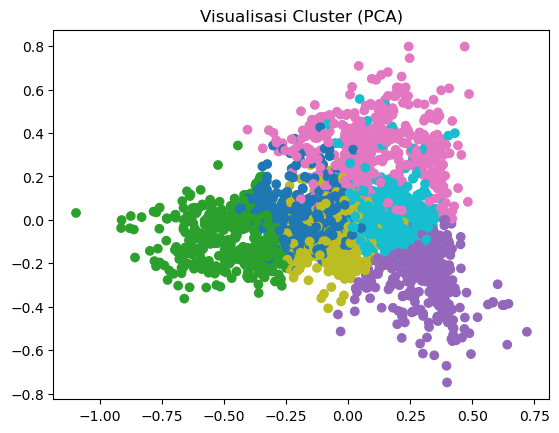

In [13]:
pca = PCA(2)
X_pca = pca.fit_transform(X_km)

plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap='tab10')
plt.title("Visualisasi Cluster (PCA)")
plt.show()


In [14]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)


In [15]:
rf = RandomForestClassifier(
    n_estimators=300,
    class_weight='balanced',
    random_state=RANDOM_STATE
)
rf.fit(X_train, y_train)

pred_rf = rf.predict(X_test)

print("=== RANDOM FOREST ===")
print(classification_report(y_test, pred_rf, digits=3))
print("Macro-F1:", f1_score(y_test, pred_rf, average='macro'))


=== RANDOM FOREST ===
              precision    recall  f1-score   support

           1      0.869     0.946     0.906       521
           2      0.727     0.646     0.684       144
           3      0.898     0.852     0.875       135
           4      0.826     0.769     0.796       117
           5      0.935     0.821     0.874       106
           6      0.750     0.500     0.600         6

    accuracy                          0.856      1029
   macro avg      0.834     0.756     0.789      1029
weighted avg      0.854     0.856     0.853      1029

Macro-F1: 0.7892383800880491


In [16]:
svm = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    class_weight='balanced',
    probability=True
)
svm.fit(X_train, y_train)

pred_svm = svm.predict(X_test)

print("=== SVM ===")
print(classification_report(y_test, pred_svm, digits=3))
print("Macro-F1:", f1_score(y_test, pred_svm, average='macro'))


=== SVM ===
              precision    recall  f1-score   support

           1      0.885     0.883     0.884       521
           2      0.625     0.625     0.625       144
           3      0.807     0.652     0.721       135
           4      0.779     0.752     0.765       117
           5      0.746     0.858     0.798       106
           6      0.286     1.000     0.444         6

    accuracy                          0.800      1029
   macro avg      0.688     0.795     0.706      1029
weighted avg      0.808     0.800     0.801      1029

Macro-F1: 0.7063307558640184


In [17]:
joblib.dump(rf, "rf_model.pkl")
joblib.dump(svm, "svm_model.pkl")
joblib.dump(scaler, "scaler.pkl")

print("Model & scaler tersimpan")


Model & scaler tersimpan
